<a href="https://colab.research.google.com/github/ArezooAalipanah/machine_learning3/blob/main/hml_ch11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 11: Training Deep Neural Networks 🦔

## Vanishing/Exploding Gradient Problem

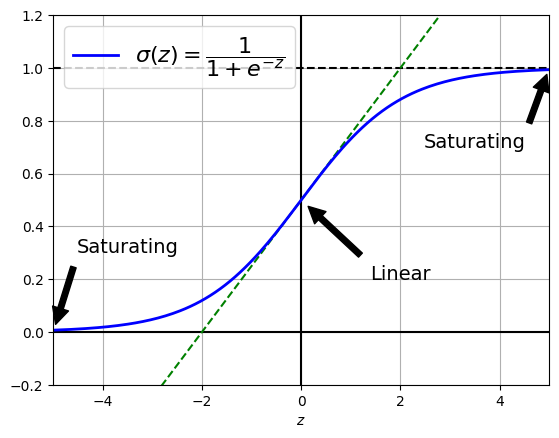

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
  return 1/ (1+ np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)


##Glorot and He Initialization

In [2]:
# setting initializations
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [3]:
#if you want He initialization with a uniform distribution and based on fanavg

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")

dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

##Better Activation Functions

### Leaky ReLU

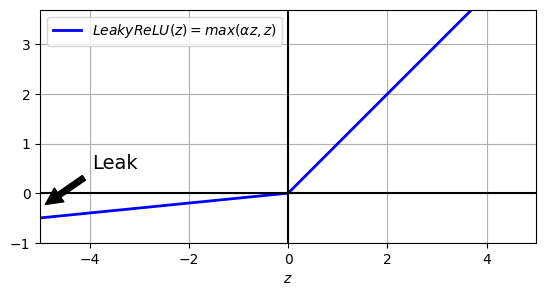

In [4]:
def leaky_relu(z, alpha):
  return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)

props = dict(facecolor='black', shrink=0.1)
plt.annotate("Leak", xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops = props,
             fontsize = 14, ha = "center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

In [5]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2) #defaults to alpha = 0.3
dense = tf.keras.layers.Dense(50, activation = leaky_relu,
                              kernel_initializer="he_normal")

In [6]:
# use leaky relu as a seperate layer in the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, kernel_initializer = "he_normal"), # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2)# activation as a seperate layer
])

### ELU

In [7]:
#Implementing ELU in TensorFlow
dense = tf.keras.layers.Dense(50, activation = "elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

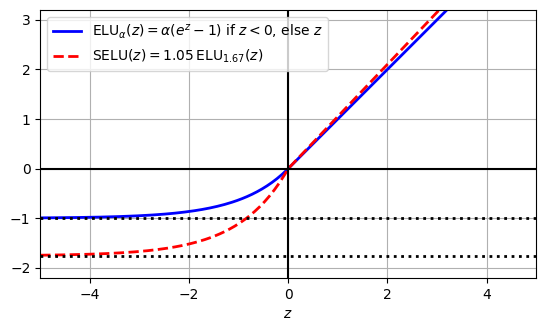

In [8]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

In [9]:
# using SELU straight forward:

dense = tf.keras.layers.Dense(50, activation = "selu",
                              kernel_initializer = "lecun_normal")

In [10]:
#example of a self-regularized network using SELU

#neural net for Fashion MNIST with 100 hidden layers,
#using the SELU activation function:

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [12]:
#let's train.Do not forget to scale the inputs to mean 0 and standard deviation 1:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 61s 25ms/step - loss: 1.4450 - accuracy: 0.4352 - val_loss: 1.0101 - val_accuracy: 0.6098
Epoch 2/5
1719/1719 [==============================] - 42s 25ms/step - loss: 0.8297 - accuracy: 0.6960 - val_loss: 0.6857 - val_accuracy: 0.7516
Epoch 3/5
1719/1719 [==============================] - 44s 26ms/step - loss: 0.6872 - accuracy: 0.7416 - val_loss: 0.6051 - val_accuracy: 0.7758
Epoch 4/5
1719/1719 [==============================] - 42s 25ms/step - loss: 0.6154 - accuracy: 0.7721 - val_loss: 0.5763 - val_accuracy: 0.7966
Epoch 5/5
1719/1719 [==============================] - 42s 24ms/step - loss: 0.5626 - accuracy: 0.7961 - val_loss: 0.5823 - val_accuracy: 0.7832


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [16]:
tf.random.set_seed(42)

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 53s 25ms/step - loss: 1.7802 - accuracy: 0.2759 - val_loss: 1.4246 - val_accuracy: 0.3456
Epoch 2/5
1719/1719 [==============================] - 40s 23ms/step - loss: 1.2473 - accuracy: 0.4350 - val_loss: 1.0550 - val_accuracy: 0.4912
Epoch 3/5
1719/1719 [==============================] - 40s 23ms/step - loss: 1.0566 - accuracy: 0.5323 - val_loss: 1.0338 - val_accuracy: 0.5734
Epoch 4/5
1719/1719 [==============================] - 40s 23ms/step - loss: 0.8889 - accuracy: 0.6192 - val_loss: 0.9185 - val_accuracy: 0.6260
Epoch 5/5
1719/1719 [==============================] - 40s 23ms/step - loss: 0.8029 - accuracy: 0.6824 - val_loss: 0.7590 - val_accuracy: 0.7188


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

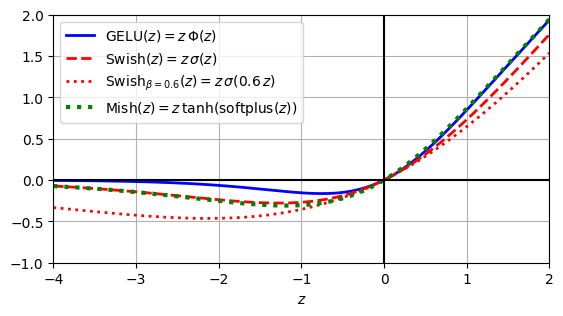

In [20]:
def swish(Z, beta=1):
  return z * sigmoid(beta * z)

def approx_gelu(z):
  return swish(z, beta =1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

## Batch Normalization

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                   kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")

])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [24]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [25]:
# just show that the model works! 😊
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd",
              metrics = "accuracy")
model.fit(X_train, y_train, epochs=2, validation_data = (X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 19s 10ms/step - loss: 0.5479 - accuracy: 0.8092 - val_loss: 0.3913 - val_accuracy: 0.8598
Epoch 2/2
1719/1719 [==============================] - 16s 10ms/step - loss: 0.4028 - accuracy: 0.8545 - val_loss: 0.3613 - val_accuracy: 0.8664


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


In [27]:
#BN before the activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer= "he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

In [28]:
# show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6088 - accuracy: 0.7981 - val_loss: 0.4327 - val_accuracy: 0.8470
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4271 - accuracy: 0.8510 - val_loss: 0.3816 - val_accuracy: 0.8642


### Gradient Clipping
All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [29]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [30]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras Model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [31]:
#  split Fashion MNIST into tasks A and B, then train and save
#  model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 8s 5ms/step - loss: 1.3052 - accuracy: 0.5492 - val_loss: 0.8118 - val_accuracy: 0.7370
Epoch 2/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.6849 - accuracy: 0.7661 - val_loss: 0.5786 - val_accuracy: 0.7982
Epoch 3/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.5362 - accuracy: 0.8228 - val_loss: 0.4851 - val_accuracy: 0.8371
Epoch 4/20
1376/1376 [==============================] - 6s 5ms/step - loss: 0.4583 - accuracy: 0.8540 - val_loss: 0.4239 - val_accuracy: 0.8634
Epoch 5/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.4094 - accuracy: 0.8693 - val_loss: 0.3883 - val_accuracy: 0.8719
Epoch 6/20
1376/1376 [==============================] - 6s 5ms/step - loss: 0.3769 - accuracy: 0.8763 - val_loss: 0.3627 - val_accuracy: 0.8721
Epoch 7/20
1376/1376 [==============================] - 8s 5ms/step - loss: 0.3549 - accuracy: 0.8816 - val_loss: 0.3448 - val_accuracy:

In [32]:
#  train and evaluate model B, without reusing model A
tf.random.set_seed(42)

model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs = 20,
                      validation_data = (X_valid_B, y_valid_B))

model_B.evaluate(X_test_B, y_test_B)


Epoch 1/20
7/7 [==============================] - 1s 62ms/step - loss: 0.7043 - accuracy: 0.5500 - val_loss: 0.6899 - val_accuracy: 0.5371
Epoch 2/20
7/7 [==============================] - 0s 22ms/step - loss: 0.6712 - accuracy: 0.5950 - val_loss: 0.6639 - val_accuracy: 0.5648
Epoch 3/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6464 - accuracy: 0.6200 - val_loss: 0.6430 - val_accuracy: 0.5806
Epoch 4/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6222 - accuracy: 0.6450 - val_loss: 0.6230 - val_accuracy: 0.6330
Epoch 5/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6018 - accuracy: 0.6650 - val_loss: 0.6027 - val_accuracy: 0.6963
Epoch 6/20
7/7 [==============================] - 0s 35ms/step - loss: 0.5812 - accuracy: 0.7500 - val_loss: 0.5847 - val_accuracy: 0.7587
Epoch 7/20
7/7 [==============================] - 0s 23ms/step - loss: 0.5620 - accuracy: 0.8100 - val_loss: 0.5682 - val_accuracy: 0.7943
Epoch 8/20
7/7 [===========

[0.43108320236206055, 0.9085000157356262]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [33]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A =tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation = "sigmoid"))


Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [34]:
tf.random.set_seed(42)

In [35]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [36]:
#creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [37]:
# we should make the layers NOT trainable to avoid changing the weights with
# huge gradients esp. on the first epochs
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer,
                     metrics = ["accuracy"])

In [38]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data = (X_valid_B, y_valid_B))


Epoch 1/4
7/7 [==============================] - 1s 83ms/step - loss: 1.0124 - accuracy: 0.2000 - val_loss: 0.9764 - val_accuracy: 0.1899
Epoch 2/4
7/7 [==============================] - 0s 31ms/step - loss: 0.9805 - accuracy: 0.2050 - val_loss: 0.9467 - val_accuracy: 0.2028
Epoch 3/4
7/7 [==============================] - 0s 31ms/step - loss: 0.9541 - accuracy: 0.2250 - val_loss: 0.9350 - val_accuracy: 0.2354
Epoch 4/4
7/7 [==============================] - 0s 31ms/step - loss: 0.9139 - accuracy: 0.2450 - val_loss: 0.8993 - val_accuracy: 0.2295


In [39]:
# after we train the model for some epochs it's time to make the layers trainable
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer,
                     metrics = ["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 16,
                           validation_data = (X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 2s 79ms/step - loss: 0.8442 - accuracy: 0.3300 - val_loss: 0.7681 - val_accuracy: 0.4055
Epoch 2/16
7/7 [==============================] - 0s 24ms/step - loss: 0.7261 - accuracy: 0.4550 - val_loss: 0.6676 - val_accuracy: 0.5252
Epoch 3/16
7/7 [==============================] - 0s 33ms/step - loss: 0.6296 - accuracy: 0.6150 - val_loss: 0.6095 - val_accuracy: 0.6706
Epoch 4/16
7/7 [==============================] - 0s 34ms/step - loss: 0.5469 - accuracy: 0.7900 - val_loss: 0.5338 - val_accuracy: 0.7992
Epoch 5/16
7/7 [==============================] - 0s 22ms/step - loss: 0.4910 - accuracy: 0.8650 - val_loss: 0.4831 - val_accuracy: 0.8625
Epoch 6/16
7/7 [==============================] - 0s 34ms/step - loss: 0.4460 - accuracy: 0.9000 - val_loss: 0.4437 - val_accuracy: 0.8863
Epoch 7/16
7/7 [==============================] - 0s 33ms/step - loss: 0.4011 - accuracy: 0.9100 - val_loss: 0.4270 - val_accuracy: 0.8882
Epoch 8/16
7/7 [===========

In [40]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.2801 - accuracy: 0.9235


[0.2801233232021332, 0.9235000014305115]

#### How science can fool you :D
Great! We got a bit of transfer: the model's accuracy went up 4 percentage points, from 89.5% to 93.5%. This means the error rate dropped by almost 40%:


In [41]:
1 - (100 - 93.5) / (100 - 89.5)

0.38095238095238093

# Faster Optimizers

In [46]:
# a little function to test an optimizer on Fashion MNIST


def build_model(seed = 42):
  tf.random.set_seed(seed)
  return tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=[28,28]),
      tf.keras.layers.Dense(100, activation="relu",
                            kernel_initializer="he_normal"),
      tf.keras.layers.Dense(100, activation = "relu",
                            kernel_initializer="he_normal"),
      tf.keras.layers.Dense(100, activation = "relu",
                            kernel_initializer="he_normal"),
      tf.keras.layers.Dense(10, activation="softmax")
      ])

def build_and_train_model(optimizer):
  model = build_model()
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
  return model.fit(X_train, y_train, epochs = 10,
                   validation_data= (X_valid, y_valid))

In [47]:
# momentum how to have it:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)


In [48]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6969 - accuracy: 0.7620 - val_loss: 0.5110 - val_accuracy: 0.8132
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4740 - accuracy: 0.8322 - val_loss: 0.4455 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4271 - accuracy: 0.8480 - val_loss: 0.4116 - val_accuracy: 0.8520
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3986 - accuracy: 0.8588 - val_loss: 0.3869 - val_accuracy: 0.8622
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3766 - accuracy: 0.8673 - val_loss: 0.3738 - val_accuracy: 0.8656
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3622 - accuracy: 0.8699 - val_loss: 0.3704 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3451 - accuracy: 0.8760 - val_loss: 0.3681 - val_a

## Momentum optimization

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)

In [50]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.6743 - accuracy: 0.7691 - val_loss: 0.5053 - val_accuracy: 0.8166
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4578 - accuracy: 0.8384 - val_loss: 0.4356 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4158 - accuracy: 0.8527 - val_loss: 0.4053 - val_accuracy: 0.8564
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3900 - accuracy: 0.8615 - val_loss: 0.3779 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3689 - accuracy: 0.8685 - val_loss: 0.3701 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3557 - accuracy: 0.8723 - val_loss: 0.3602 - val_accuracy: 0.8708
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3392 - accuracy: 0.8771 - val_loss: 0.3500 - val_a

## Nesterov Accelerated Gradient

In [51]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9,
                                    nesterov = True)

In [52]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.6831 - accuracy: 0.7664 - val_loss: 0.4913 - val_accuracy: 0.8270
Epoch 2/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.4624 - accuracy: 0.8371 - val_loss: 0.4376 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4191 - accuracy: 0.8513 - val_loss: 0.3971 - val_accuracy: 0.8584
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3925 - accuracy: 0.8618 - val_loss: 0.3808 - val_accuracy: 0.8644
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3722 - accuracy: 0.8677 - val_loss: 0.3633 - val_accuracy: 0.8732
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3586 - accuracy: 0.8723 - val_loss: 0.3774 - val_accuracy: 0.8668
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3424 - accuracy: 0.8766 - val_loss: 0.3766 - val_a

## AdaGrad

In [53]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.001)

In [55]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 1.0555 - accuracy: 0.6730 - val_loss: 0.7004 - val_accuracy: 0.7698
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6501 - accuracy: 0.7825 - val_loss: 0.5995 - val_accuracy: 0.8016
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5825 - accuracy: 0.8061 - val_loss: 0.5536 - val_accuracy: 0.8160
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5458 - accuracy: 0.8182 - val_loss: 0.5263 - val_accuracy: 0.8240
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5213 - accuracy: 0.8254 - val_loss: 0.5059 - val_accuracy: 0.8286
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5031 - accuracy: 0.8304 - val_loss: 0.4926 - val_accuracy: 0.8310
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4888 - accuracy: 0.8353 - val_loss: 0.4801 - val_acc

## RMSProp

In [57]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001, rho = 0.9)

In [58]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5147 - accuracy: 0.8139 - val_loss: 0.4052 - val_accuracy: 0.8506
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3912 - accuracy: 0.8597 - val_loss: 0.4598 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3639 - accuracy: 0.8691 - val_loss: 0.3758 - val_accuracy: 0.8738
Epoch 4/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3585 - accuracy: 0.8741 - val_loss: 0.4070 - val_accuracy: 0.8694
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3519 - accuracy: 0.8773 - val_loss: 0.4287 - val_accuracy: 0.8510
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3462 - accuracy: 0.8803 - val_loss: 0.4485 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3501 - accuracy: 0.8797 - val_loss: 0.3956 - val_

## Adam Optimization

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9,
                                     beta_2=0.999)

In [60]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 0.4981 - accuracy: 0.8222 - val_loss: 0.4105 - val_accuracy: 0.8412
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3767 - accuracy: 0.8633 - val_loss: 0.3776 - val_accuracy: 0.8554
Epoch 3/10
1719/1719 [==============================] - 16s 10ms/step - loss: 0.3403 - accuracy: 0.8756 - val_loss: 0.3397 - val_accuracy: 0.8742
Epoch 4/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3169 - accuracy: 0.8827 - val_loss: 0.3400 - val_accuracy: 0.8796
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2989 - accuracy: 0.8890 - val_loss: 0.3357 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2851 - accuracy: 0.8939 - val_loss: 0.3583 - val_accuracy: 0.8744
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2726 - accuracy: 0.8977 - val_loss: 0.3432 - val

### Adamax Optimization

In [61]:
optimizer = tf.keras.optimizers.Adamax(learning_rate= 0.001, beta_1=0.9,
                                       beta_2=0.999)

In [62]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 18s 9ms/step - loss: 0.5469 - accuracy: 0.8093 - val_loss: 0.4581 - val_accuracy: 0.8278
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3975 - accuracy: 0.8573 - val_loss: 0.3972 - val_accuracy: 0.8540
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3606 - accuracy: 0.8703 - val_loss: 0.3875 - val_accuracy: 0.8654
Epoch 4/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3352 - accuracy: 0.8794 - val_loss: 0.3540 - val_accuracy: 0.8742
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3145 - accuracy: 0.8867 - val_loss: 0.3315 - val_accuracy: 0.8752
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3004 - accuracy: 0.8908 - val_loss: 0.3460 - val_accuracy: 0.8776
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2878 - accuracy: 0.8939 - val_loss: 0.3373 - val_

### Nadam optimization

In [64]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001, beta_1 = 0.9,
                                      beta_2 = 0.999)

In [65]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 15s 7ms/step - loss: 0.4800 - accuracy: 0.8280 - val_loss: 0.4272 - val_accuracy: 0.8378
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3643 - accuracy: 0.8668 - val_loss: 0.3650 - val_accuracy: 0.8608
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3331 - accuracy: 0.8780 - val_loss: 0.3440 - val_accuracy: 0.8796
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3115 - accuracy: 0.8851 - val_loss: 0.3246 - val_accuracy: 0.8812
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2913 - accuracy: 0.8907 - val_loss: 0.3417 - val_accuracy: 0.8756
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2772 - accuracy: 0.8968 - val_loss: 0.3729 - val_accuracy: 0.8698
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 0.3490 - val_ac

### AdamW optimization

In [66]:
#On Colab or Kaggle, we need to install the TensorFlow-Addons library:
%pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 15.7 MB/s eta 0:00:00


In [69]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(weight_decay = 1e-5, learning_rate = 0.001,
                                beta_1 = 0.9, beta_2 = 0.999)

In [70]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4965 - accuracy: 0.8214 - val_loss: 0.4180 - val_accuracy: 0.8364
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3722 - accuracy: 0.8651 - val_loss: 0.3976 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3393 - accuracy: 0.8764 - val_loss: 0.3400 - val_accuracy: 0.8696
Epoch 4/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3170 - accuracy: 0.8830 - val_loss: 0.3373 - val_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2980 - accuracy: 0.8889 - val_loss: 0.3351 - val_accuracy: 0.8738
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2844 - accuracy: 0.8936 - val_loss: 0.3397 - val_accuracy: 0.8734
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2714 - accuracy: 0.8970 - val_loss: 0.3379 - val_a

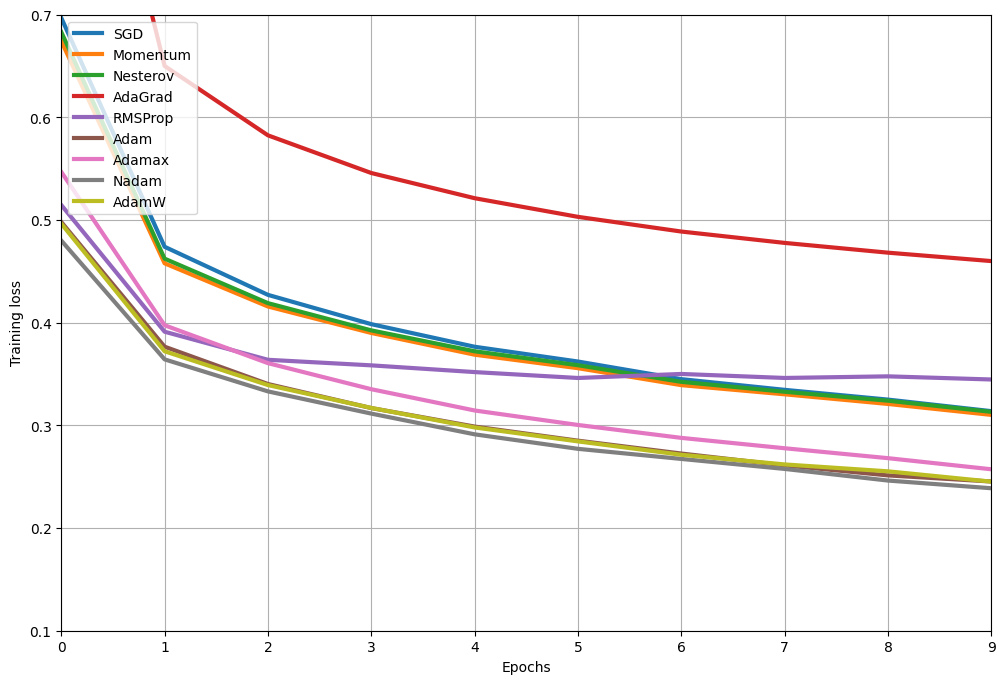

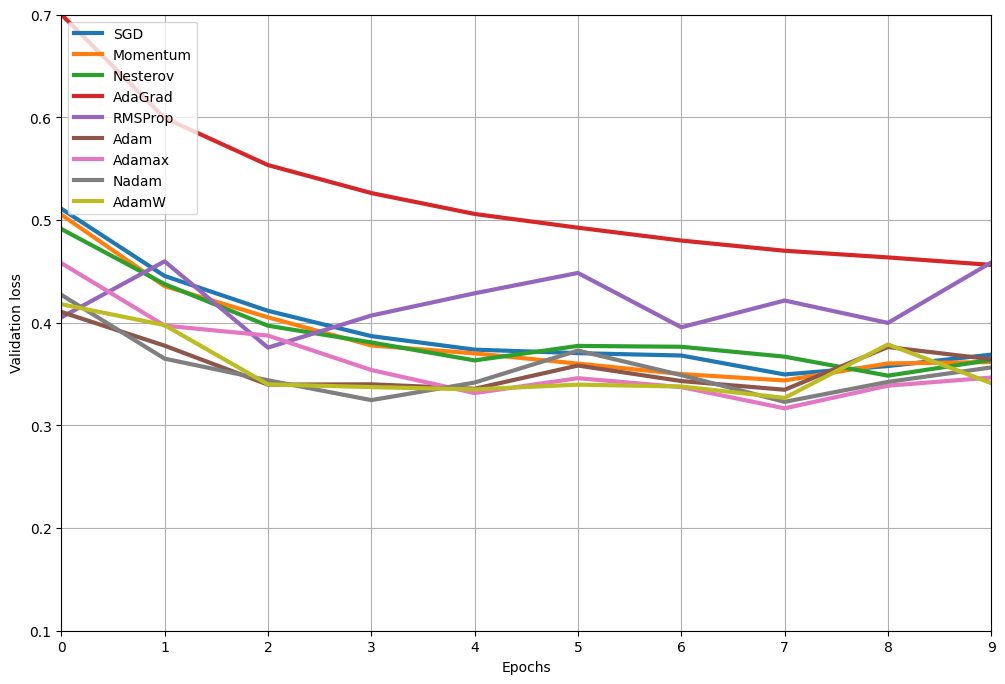

In [71]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# Learning Rate Scheduling

###Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [77]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)


optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [78]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 20s 11ms/step - loss: 0.6921 - accuracy: 0.7615 - val_loss: 0.4967 - val_accuracy: 0.8238
Epoch 2/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4763 - accuracy: 0.8311 - val_loss: 0.4688 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4283 - accuracy: 0.8473 - val_loss: 0.4328 - val_accuracy: 0.8436
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4016 - accuracy: 0.8575 - val_loss: 0.3907 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3794 - accuracy: 0.8640 - val_loss: 0.3838 - val_accuracy: 0.8632
Epoch 6/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3613 - accuracy: 0.8706 - val_loss: 0.3861 - val_accuracy: 0.8642
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3492 - accuracy: 0.8732 - val_loss: 0.3612 - va

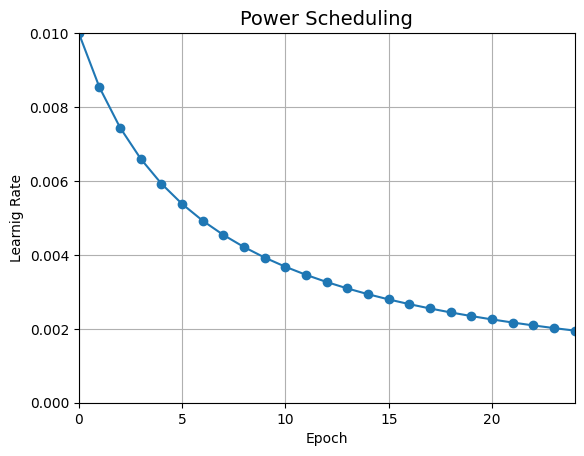

In [81]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate/ (1 + decay * epochs * n_steps_per_epoch)
plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs -1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learnig Rate")
plt.title("Power Scheduling", fontsize = 14)
plt.grid(True)
plt.show()



### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [82]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1 ** (epoch / 20)

In [87]:
# if we wanna use other lr0s :
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch/ s)
  return exponential_decay_fn # return the whole function

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

In [88]:
# build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [89]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs = n_epochs,
                    validation_data = (X_valid, y_valid),
                    callbacks = [lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6951 - accuracy: 0.7628 - val_loss: 0.4865 - val_accuracy: 0.8284 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4744 - accuracy: 0.8323 - val_loss: 0.4562 - val_accuracy: 0.8346 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4293 - accuracy: 0.8485 - val_loss: 0.4147 - val_accuracy: 0.8534 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4055 - accuracy: 0.8573 - val_loss: 0.3931 - val_accuracy: 0.8586 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3858 - accuracy: 0.8627 - val_loss: 0.3864 - val_accuracy: 0.8576 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3707 - accuracy: 0.8684 - val_loss: 0.3907 - val_accuracy: 0.8600 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================]

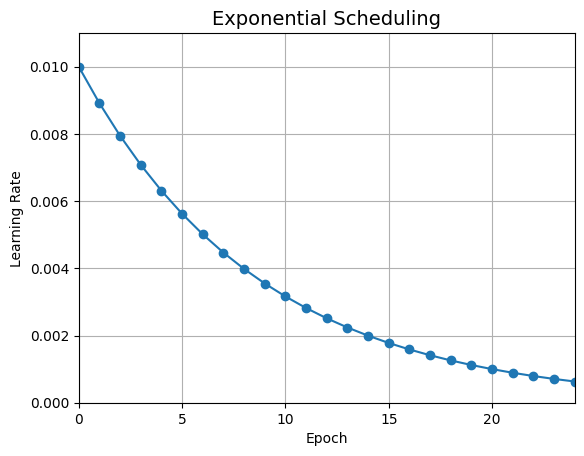

In [90]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [92]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [93]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
  def __init__(self, n_steps = 40_000):
    super().__init__()
    self.n_steps =  n_steps

  def on_batch_begin(self, batch, logs=None):
    # Note: the `batch` argument is reset at each epoch
    lr = K.get_value(self.model.optimizer.learning_rate)
    new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
    K.set_value(self.model.optimizer.learning_rate, new_learning_rate)


  def on_epoch_end(self, epoch, logs=None):
     logs = logs or {}
     logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [94]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [95]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 13s 6ms/step - loss: 0.7113 - accuracy: 0.7575 - val_loss: 0.4943 - val_accuracy: 0.8264 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4784 - accuracy: 0.8315 - val_loss: 0.4628 - val_accuracy: 0.8330 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 18s 11ms/step - loss: 0.4322 - accuracy: 0.8459 - val_loss: 0.4344 - val_accuracy: 0.8474 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4088 - accuracy: 0.8552 - val_loss: 0.3990 - val_accuracy: 0.8608 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3886 - accuracy: 0.8620 - val_loss: 0.3905 - val_accuracy: 0.8608 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 18s 11ms/step - loss: 0.3732 - accuracy: 0.8673 - val_loss: 0.3937 - val_accuracy: 0.8638 - lr: 0.0058
Epoch 7/25
1719/1719 [============================

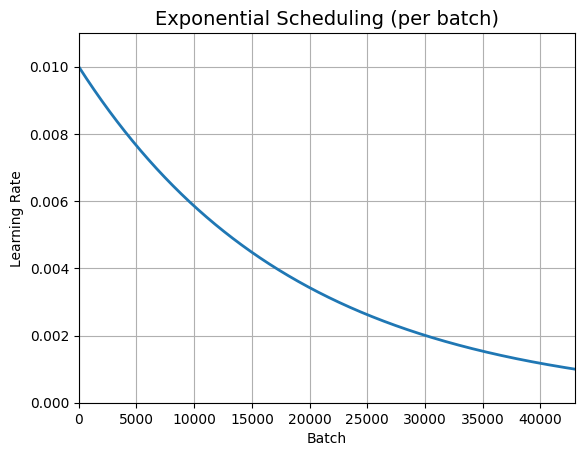

In [96]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

###Piecewise Constant Scheduling

In [98]:
def piecewise_constant_fn(epoch):
  if epoch < 5:
    return 0.01
  elif epoch < 15:
    return 0.005
  else:
    return 0.001

In [99]:
# general way to define piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [100]:
# use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 7ms/step - loss: 0.5431 - accuracy: 0.8067 - val_loss: 0.4870 - val_accuracy: 0.8218 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4492 - accuracy: 0.8435 - val_loss: 0.4915 - val_accuracy: 0.8262 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4320 - accuracy: 0.8484 - val_loss: 0.4658 - val_accuracy: 0.8486 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4170 - accuracy: 0.8545 - val_loss: 0.4296 - val_accuracy: 0.8488 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4040 - accuracy: 0.8593 - val_loss: 0.4166 - val_accuracy: 0.8538 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3527 - accuracy: 0.8742 - val_loss: 0.3853 - val_accuracy: 0.8632 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

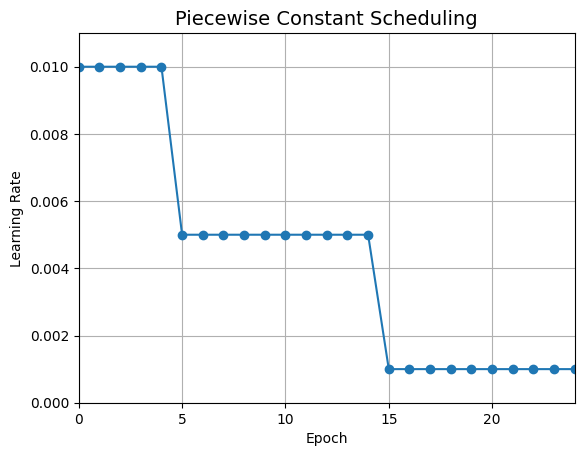

In [101]:
# plot piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [102]:
# build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [103]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6967 - accuracy: 0.7583 - val_loss: 0.4998 - val_accuracy: 0.8232 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4719 - accuracy: 0.8335 - val_loss: 0.4518 - val_accuracy: 0.8378 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4223 - accuracy: 0.8511 - val_loss: 0.4114 - val_accuracy: 0.8538 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3960 - accuracy: 0.8594 - val_loss: 0.3883 - val_accuracy: 0.8624 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3749 - accuracy: 0.8669 - val_loss: 0.3794 - val_accuracy: 0.8614 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3582 - accuracy: 0.8722 - val_loss: 0.3771 - val_accuracy: 0.8658 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] -

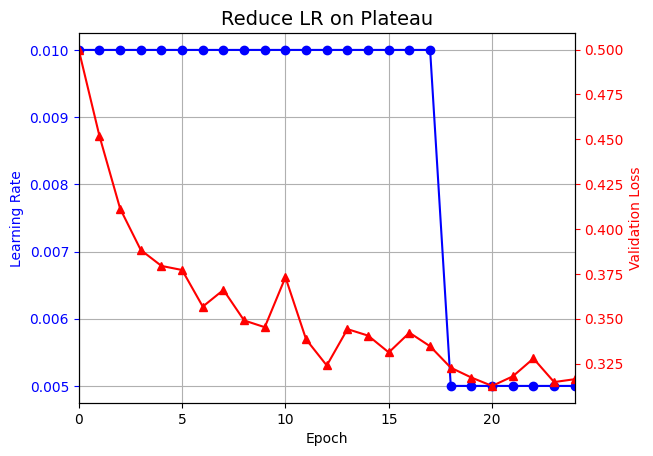

In [104]:
# this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras.schedulers

In [105]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [106]:
#build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6772 - accuracy: 0.7704 - val_loss: 0.4941 - val_accuracy: 0.8220
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4676 - accuracy: 0.8349 - val_loss: 0.4543 - val_accuracy: 0.8344
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4214 - accuracy: 0.8499 - val_loss: 0.4125 - val_accuracy: 0.8526
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3978 - accuracy: 0.8594 - val_loss: 0.3793 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3791 - accuracy: 0.8655 - val_loss: 0.3774 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3647 - accuracy: 0.8704 - val_loss: 0.3831 - val_accuracy: 0.8666
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3546 - accuracy: 0.8724 - val_loss: 0.3626 - val_accurac

In [108]:
# For piecewise constant scheduling, try this:

# how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [110]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
  def __init__(self, factor):
    self.factor = factor
    self.rates = []
    self.losses = []

  def on_epoch_begin(self, epoch, logs=None):
      self.sum_of_epoch_losses = 0

  def on_batch_end(self, batch, logs=None):
      mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
      new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
      batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
      self.sum_of_epoch_losses = new_sum_of_epoch_losses
      self.rates.append(K.get_value(self.model.optimizer.learning_rate))
      self.losses.append(batch_loss)
      K.set_value(self.model.optimizer.learning_rate,
                  self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [111]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [112]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [113]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 4s 8ms/step - loss: 1.9245 - accuracy: 0.3750


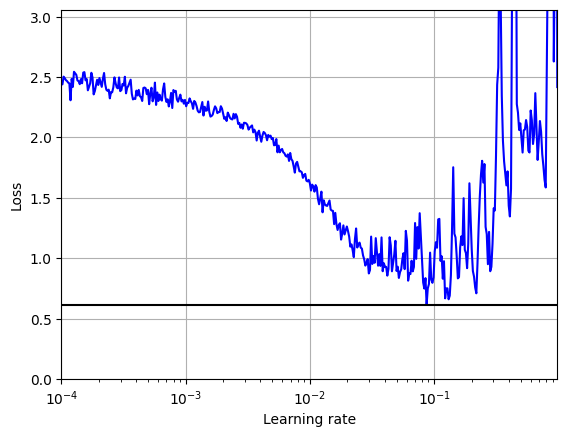

In [114]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [115]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [116]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 5s 10ms/step - loss: 0.9124 - accuracy: 0.6893 - val_loss: 0.5857 - val_accuracy: 0.8016
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.5580 - accuracy: 0.8036 - val_loss: 0.4952 - val_accuracy: 0.8268
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4944 - accuracy: 0.8227 - val_loss: 0.4491 - val_accuracy: 0.8418
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4503 - accuracy: 0.8391 - val_loss: 0.4226 - val_accuracy: 0.8470
Epoch 5/25
430/430 [==============================] - 4s 10ms/step - loss: 0.4236 - accuracy: 0.8483 - val_loss: 0.4137 - val_accuracy: 0.8454
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3996 - accuracy: 0.8567 - val_loss: 0.5561 - val_accuracy: 0.8008
Epoch 7/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3861 - accuracy: 0.8602 - val_loss: 0.3984 - val_accuracy: 0.8502
Epoc

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [117]:
layer = tf.keras.layers.Dense(100, activation = "relu",
                              kernel_initializer ="he_normal",
                              kernel_regularizer = tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [118]:
tf.random.set_seed(42)

In [119]:
from keras import regularizers
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation = "relu",
                           kernel_initializer = "he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation = "softmax"),
])

In [121]:
# compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.02)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=optimizer,
              metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data = (X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 5ms/step - loss: 3.1325 - accuracy: 0.7705 - val_loss: 1.8671 - val_accuracy: 0.8238
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.4308 - accuracy: 0.8133 - val_loss: 1.1319 - val_accuracy: 0.8156


## Dropout

In [123]:
tf.random.set_seed(42)

In [125]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer = "he_normal"),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer = "he_normal"),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [128]:
# compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs = 10,
                    validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6837 - accuracy: 0.7496 - val_loss: 0.4568 - val_accuracy: 0.8218
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5122 - accuracy: 0.8133 - val_loss: 0.4161 - val_accuracy: 0.8410
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4751 - accuracy: 0.8251 - val_loss: 0.4004 - val_accuracy: 0.8490
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4488 - accuracy: 0.8359 - val_loss: 0.3862 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4354 - accuracy: 0.8392 - val_loss: 0.3668 - val_accuracy: 0.8602
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.4261 - accuracy: 0.8415 - val_loss: 0.3730 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4132 - accuracy: 0.8471 - val_loss: 0.3689 - val_a

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [129]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3145 - accuracy: 0.8846


[0.314504474401474, 0.8845636248588562]

In [130]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3681 - accuracy: 0.8672


[0.3680601418018341, 0.8672000169754028]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [131]:
tf.random.set_seed(42)

In [133]:
y_probas = np.stack([model(X_test, training = True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [134]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 148ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.013, 0.   , 0.291, 0.   ,
        0.696]], dtype=float32)

In [135]:
y_proba[0].round(3) #it becomes less sure

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.08 , 0.   , 0.303, 0.001,
       0.615], dtype=float32)

In [136]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.001, 0.001, 0.001, 0.001, 0.   , 0.131, 0.001, 0.217, 0.005,
       0.246], dtype=float32)

In [137]:
y_pred = y_proba.argmax(axis = 1)

In [138]:
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8668

In [139]:
# to make a class
class MCDropout(tf.keras.layers.Dropout):
  def call(self, inputs, training=None):
    return super().call(inputs, training = True)

In [140]:
#convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [141]:
mc_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_96 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_97 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_98 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [142]:
# the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 26ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.3 , 0.  , 0.62]],
      dtype=float32)

## Max Norm

In [145]:
dense = tf.keras.layers.Dense(
    100, activation = "relu", kernel_initializer ="he_normal",
    kernel_constraint = tf.keras.constraints.max_norm(1.))


In [146]:
# how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 8ms/step - loss: 0.5454 - accuracy: 0.8052 - val_loss: 0.4393 - val_accuracy: 0.8268
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4083 - accuracy: 0.8511 - val_loss: 0.4170 - val_accuracy: 0.8420
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3771 - accuracy: 0.8610 - val_loss: 0.3804 - val_accuracy: 0.8652
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3597 - accuracy: 0.8689 - val_loss: 0.3645 - val_accuracy: 0.8666
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3444 - accuracy: 0.8725 - val_loss: 0.3492 - val_accuracy: 0.8678
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3375 - accuracy: 0.8753 - val_loss: 0.3785 - val_accuracy: 0.8682
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3287 - accuracy: 0.8766 - val_loss: 0.4097 - val_accu

In [147]:
#DONE!